In [1]:
from datasets import load_dataset, load_from_disk
import pandas as pd
import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModel 
import numpy as np
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
from dotenv import load_dotenv

#Loading the environment variables
load_dotenv() 

PROJECT_DIR = os.getenv("PROJECT_DIR")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)

Using device: cuda


In [2]:
#loading pretrained model
model_ckpt = 'distilbert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)
model = AutoModel.from_pretrained(model_ckpt).to(device)

/home/pol/Documents/Learning/nlp_transformers_labs/.venv/lib/python3.11/site-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [3]:
#extracting last hidden states
text = "This is a test sentence"
inputs = tokenizer(text, return_tensors='pt').to(device)
print(f"Input shape: {inputs['input_ids'].shape}")

with torch.no_grad():
    outputs = model(**inputs)
print(f"Outputs: {outputs}")
print(f"Last hidden state shape: {outputs.last_hidden_state.shape}")

Input shape: torch.Size([1, 7])
Outputs: BaseModelOutput(last_hidden_state=tensor([[[-0.2189, -0.1915, -0.0067,  ..., -0.0973,  0.0517,  0.4798],
         [-0.5847, -0.5740, -0.1525,  ..., -0.2300,  0.3013,  0.4379],
         [-0.4721, -0.3686,  0.0454,  ..., -0.0966, -0.0936,  0.9945],
         ...,
         [ 0.3245, -0.3735, -0.0680,  ..., -0.5482,  0.0609, -0.3396],
         [ 0.0457, -0.2219, -0.2684,  ..., -0.1045, -0.0945, -0.2372],
         [ 0.9335,  0.0091, -0.4542,  ...,  0.1790, -0.8192, -0.1947]]],
       device='cuda:0'), hidden_states=None, attentions=None)
Last hidden state shape: torch.Size([1, 7, 768])


In [4]:
#It is common to use the first hidden state, associated with [CLS]
# WHY!? I guess it is because this hidden state has information of the relationships between the words in the sentence
# since it is the final output and the self attention mechanism allows the model to learn the relationships between the words

print(f"First hidden state: {outputs.last_hidden_state[:,0].shape}")

def extract_hidden_states(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #Extracting the last hidden state
    with torch.no_grad():
        las_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": las_hidden_state[:,0].cpu().numpy()}

# I want to test it by doing the average of all hidden states, and not picking the first one
def extract_hidden_states_avg(batch):
    inputs = {k: v.to(device) for k, v in batch.items() if k in tokenizer.model_input_names}
    #Extracting the last hidden state
    with torch.no_grad():
        las_hidden_state = model(**inputs).last_hidden_state
    return {"hidden_state": las_hidden_state.cpu().numpy().mean(axis=1)}


First hidden state: torch.Size([1, 768])


In [5]:
#Tokenizing the whole dataset
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)

#Load back the emotions dataset
emotions = load_dataset("emotion", trust_remote_code=True)
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

#set format
emotions_encoded.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])



Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [6]:
#Extracting the hidden states
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True) # default abtch size is 1000
emotions_hidden_mean = emotions_encoded.map(extract_hidden_states_avg, batched=True) # default abtch size is 1000
emotions_hidden_mean

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'attention_mask', 'hidden_state'],
        num_rows: 2000
    })
})

In [7]:
#Save the hidden states datasets to disk (i am in my home town running this on a 2017 cpu, everything takes forever)

emotions_hidden.save_to_disk(os.path.join(PROJECT_DIR, 'data/datasets/emotions_hidden.hf'))
emotions_hidden_mean.save_to_disk(os.path.join(PROJECT_DIR, 'data/datasets/emotions_hidden_mean.hf'))


Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/16000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/2000 [00:00<?, ? examples/s]

In [8]:
#load datasets from disk
emotions_hidden =  load_from_disk(os.path.join(PROJECT_DIR, 'data/datasets/emotions_hidden.hf'))
emotions_hidden_mean =  load_from_disk(os.path.join(PROJECT_DIR, 'data/datasets/emotions_hidden_mean.hf'))

In [9]:
#creating a feature matrix
X_train = np.array(emotions_hidden['train']['hidden_state'])
X_valid = np.array(emotions_hidden['validation']['hidden_state'])
y_train = emotions_encoded['train']['label']
y_valid = emotions_encoded['validation']['label']
print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)

#creating a feature matrix
X_train_mean = np.array(emotions_hidden_mean['train']['hidden_state'])
X_valid_mean = np.array(emotions_hidden_mean['validation']['hidden_state'])
y_train_mean = emotions_encoded['train']['label']
y_valid_mean = emotions_encoded['validation']['label']
print(X_train_mean.shape, X_valid_mean.shape, y_train_mean.shape, y_valid_mean.shape)



(16000, 768) (2000, 768) torch.Size([16000]) torch.Size([2000])
(16000, 768) (2000, 768) torch.Size([16000]) torch.Size([2000])


In [10]:
# scale features to be in the range (0, 1)
x_scaled = MinMaxScaler().fit_transform(X_train)
#initiate UMAP
mapper = UMAP(n_components=2, metric='cosine').fit(x_scaled)
#dataframe of 2D UMAP embeddings
df_emb = pd.DataFrame(mapper.embedding_, columns=['X', 'Y'])
df_emb['label'] = y_train
df_emb.head()

,X,Y,label
0,4.127025,6.566102,0
1,-3.142537,5.634628,0
2,5.216112,3.248148,3
3,-2.307994,3.884936,2
4,-3.351090,3.675858,3


In [11]:
#scale the mean features
x_scaled_mean = MinMaxScaler().fit_transform(X_train_mean)
#initiate UMAP
mapper_mean = UMAP(n_components=2, metric='cosine').fit(x_scaled_mean)
#dataframe of 2D UMAP embeddings
df_emb_mean = pd.DataFrame(mapper_mean.embedding_, columns=['X', 'Y'])
df_emb_mean['label'] = y_train_mean
df_emb_mean.head()

,X,Y,label
0,2.133727,4.970811,0
1,1.889832,1.880251,0
2,2.977298,3.792173,3
3,2.411177,1.383866,2
4,0.560645,5.010979,3


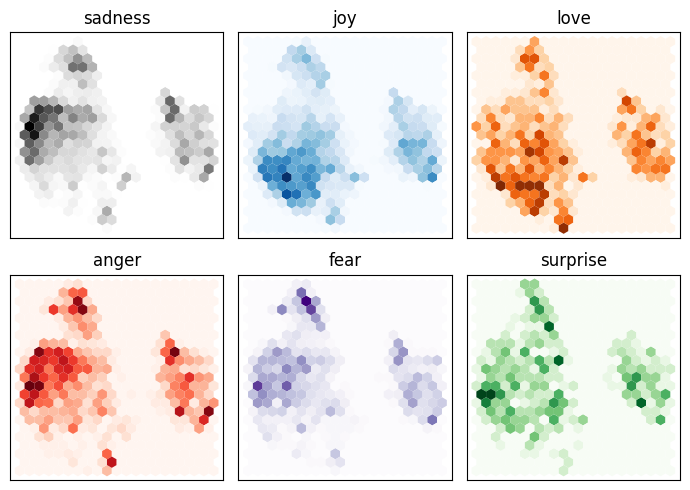

In [12]:
# Plotting the embeddings
fig,axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], gridsize=20, cmap=cmap, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]); axes[i].set_yticks([])
plt.tight_layout()
plt.show()

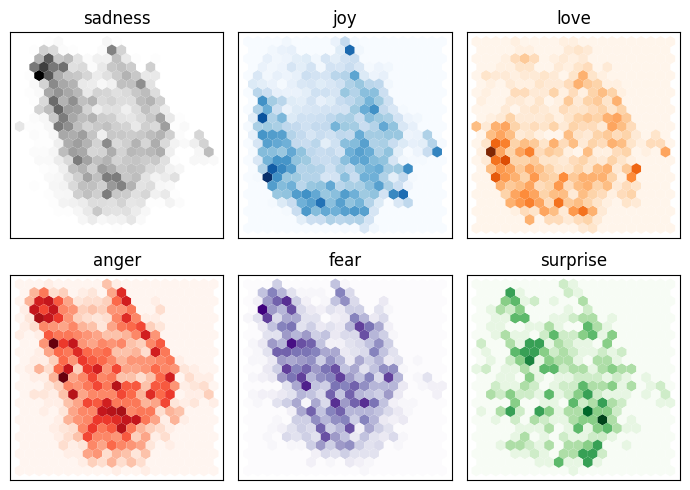

In [13]:
# Plotting the embeddings for the mean hidden states
fig,axes = plt.subplots(2, 3, figsize=(7, 5))
axes = axes.flatten()
cmaps = ['Greys', 'Blues', 'Oranges', 'Reds', 'Purples', 'Greens']
labels = emotions['train'].features['label'].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb_mean.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub['X'], df_emb_sub['Y'], gridsize=20, cmap=cmap, linewidths=(0,))
    axes[i].set_title(label)
    axes[i].set_xticks([]); axes[i].set_yticks([])
plt.tight_layout()
plt.show()

In [14]:
# YEY! Looks like the mean hidden states have a better separation between the classes (small difference, though)
#Training a simple calssifier
lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)
print(lr_clf.score(X_valid, y_valid))

#Training a simple calssifier with the mean hidden states
lr_clf_mean = LogisticRegression(max_iter=3000)
lr_clf_mean.fit(X_train_mean, y_train_mean)
print(lr_clf_mean.score(X_valid_mean, y_valid_mean))

#Dummy classifier
dummy_clf = DummyClassifier(strategy='most_frequent')
dummy_clf.fit(X_train, y_train)
print(dummy_clf.score(X_valid, y_valid))

0.6345
0.654
0.352


In [15]:
#reports 
y_pred = lr_clf.predict(X_valid)
print(classification_report(y_valid, y_pred, target_names=emotions['train'].features['label'].names))

y_pred_mean = lr_clf_mean.predict(X_valid_mean)
print(classification_report(y_valid_mean, y_pred_mean, target_names=emotions['train'].features['label'].names))

              precision    recall  f1-score   support

     sadness       0.65      0.71      0.68       550
         joy       0.71      0.80      0.75       704
        love       0.49      0.30      0.37       178
       anger       0.51      0.44      0.47       275
        fear       0.55      0.56      0.56       212
    surprise       0.55      0.27      0.36        81

    accuracy                           0.63      2000
   macro avg       0.58      0.51      0.53      2000
weighted avg       0.62      0.63      0.62      2000

              precision    recall  f1-score   support

     sadness       0.65      0.74      0.69       550
         joy       0.73      0.79      0.75       704
        love       0.55      0.38      0.45       178
       anger       0.61      0.49      0.55       275
        fear       0.54      0.54      0.54       212
    surprise       0.60      0.35      0.44        81

    accuracy                           0.65      2000
   macro avg       0.61

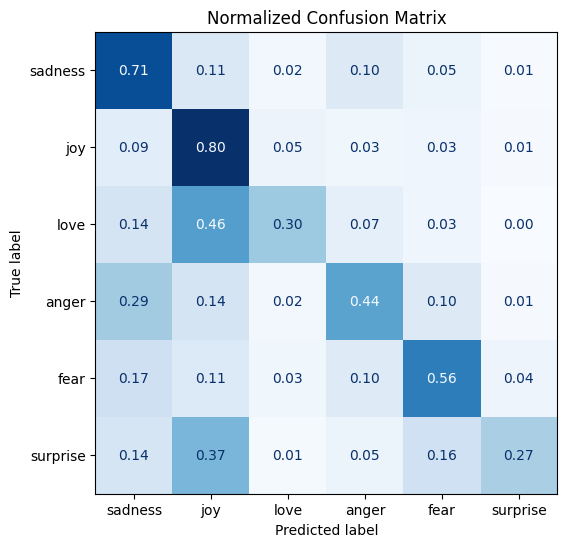

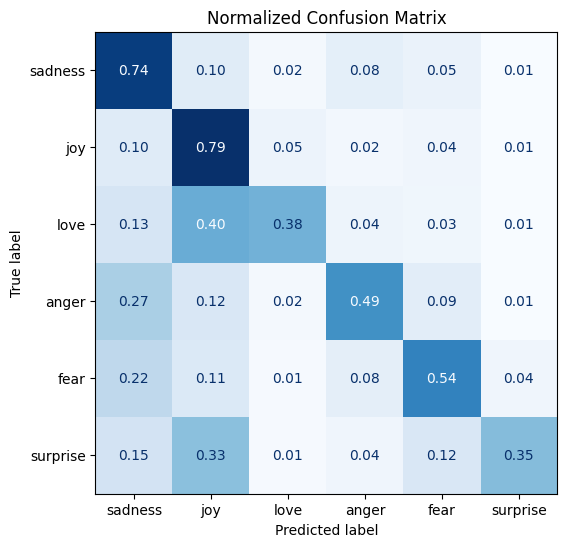

In [16]:
#plot confusion matrices
def plot_confusion_matrix(y_pred, y_true, labels):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap='Blues', values_format='.2f', ax=ax, colorbar=False)
    plt.title('Normalized Confusion Matrix')
    plt.show()

plot_confusion_matrix(y_pred, y_valid, emotions['train'].features['label'].names)

plot_confusion_matrix(y_pred_mean, y_valid_mean, emotions['train'].features['label'].names)